# Scholarship Allocation Tool: Pre-processing

# Guide: <a id='guide'></a>
## 1. [Import libraries](#import)
## 2. [Text analysis: cosine similarity](#cossim)
 - 2a. [Import and Clean the data](#cleanreal)
 - 2b. [Text analysis: tokenize, normalize, vectorize](#textanalysis)
 - 2c. [Visualize results](#viz)
 - 2d. [Text analysis summary](#summarytext)

## 3.[Linear regression models](#regression)
 - [3a. Import data](#'fabdata')
 - 3b. Model features
    - [Table of parameter combinations](#paramcombos)
    - Correlation heatmap
 - [3c. Linear regression model](#model)
    - [Linear regression: full model](#fullmodel)
    - [Linear regression: reduced model](#reducedmodel)
 - [3d. Poisson, Generalized Linear Model](#poisson)
 - [3e. Ridge regressor](#ridge) 

## 4. Model evaluation and summary
__________

# 1. Import libraries<a id='import'></a>

## Import libraries

In [1]:
# Import the libraries
import requests
import io

import pandas as pd
import numpy as np

from IPython.display import display
pd.options.display.max_columns = None

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = [11, 8]

import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot

<a id='cossim'></a>
# 2. Text analysis: cosine similarity

<br>The dataset consists of 22 entries by scholarship applicants describing financial circumstances. Each text entry has an associated percent_eligibility value, which is the amount of scholarship the applicant was eligible for.
<br>
<br>**Question**: Can text entries desribing a fmaily's additional financial circumstances predict the amount of scholarship the applicant would be awarded based on hosehold income and other quantities?
<br>**Method**: Text samples were tokenized and a bag-of-words approach was used. Cosine similarity was calculated for all pairs of text entries in the dataset. The relationship, or lack of, between similarity scores and percent eligibility difference was explored.
<br>
<br>**Expected result:** if text can predict eligibility, we will see that as cosine similarity scores approach 1, indicating 100 percent similarity, percent eligibility will also become more similar and the difference between the percent eligibility values in each pair will approach zero.


**Reources:**
<br> text processing
<br> https://stackoverflow.com/questions/65199011/is-there-a-way-to-check-similarity-between-two-full-sentences-in-python

<br>modeling
<br>https://www.kaggle.com/code/jonathanoheix/sentiment-analysis-with-hotel-reviews/notebook

<br>other
<br>https://medium.com/analytics-vidhya/predict-public-review-ratings-a-preview-of-natural-language-processing-series-14953f5a126d
<br>https://medium.com/data-science-lab-spring-2021/amazon-review-rating-prediction-with-nlp-28a4acdd4352
<br>https://github.com/acfilok96/Amazon-Review-Rating-Prediction-with-NLP-/blob/main/File/3.Data_Text_To_Numeric.ipynb

Sklearn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

[To Guide](#guide)
<a id='cleanreal'></a>
## 2a. Data import and cleaning

In [2]:
# Text based analysis. Do notes predict award?
# cosine distance between two text inputs
# are certain notes more likely to be awarded?

# tokenize, bag of words
# distance


In [3]:
# CODE SOURCE: https://sites.temple.edu/tudsc/2017/03/30/measuring-similarity-between-texts-in-python/#:~:text=The%20cosine%20similarity%20is%20the,the%20similarity%20between%20two%20documents.

In [4]:
#get anonymized real data past years from GitHub: Floydworks
url = ('https://raw.githubusercontent.com/Floydworks/Capstone_3-R.Sandidge-/main/data_files/df_pastreal_allotment.csv')
download = requests.get(url).content
# Read the downloaded content and turn it into a pandas dataframe
df_pastreal_allotment = pd.read_csv(io.StringIO(download.decode('utf-8'))).iloc[:, 1:]


df_pastreal_allotment.head()

,Name,household_income,Notes,year,number_adults,number_children,single,additional_expenses,employment,divorce,medical,education,immigration,housing,total_circumstances,percent_award,circumstance_cost,disposable_unit,extra_cost,single_parent_cost,family_base_income,family_need_income,disposable_income,family_disposable_unit,percent_eligible
0,x,30000.0,none,2019,2,3,0,none,0,0,0,0,0,0,0,40.0,1000,5000,0.0,0.0,98591.66667,98591.66667,-68591.66667,20000,90
1,x,50000.0,none,2019,1,1,1,none,0,0,0,0,0,0,0,60.0,1000,5000,5359.0,5359.0,55569.66667,60928.66667,-10928.66667,7500,90
2,x,26800.0,did not attend RL Orientation with her buddy....,2019,1,1,1,Reina did not attend RL Orientation with her b...,0,0,0,0,0,0,0,40.0,1000,5000,5359.0,5359.0,55569.66667,60928.66667,-34128.66667,7500,90
3,x,50000.0,none,2019,1,1,1,none,0,0,0,0,0,0,0,100.0,1000,5000,5359.0,5359.0,55569.66667,60928.66667,-10928.66667,7500,90
4,x,102912.0,Mom is sole provider for elderly mother and he...,2020,3,1,0,Mom is sole provider for elderly mother and he...,0,0,0,0,0,0,0,90.0,1000,5000,0.0,0.0,64032.66667,64032.66667,38879.33333,12500,0


In [5]:
#get filtered dataframe with only two needed columns
df_past = df_pastreal_allotment[['Notes', 'percent_eligible']]

df_past['Notes'] = df_past.Notes.replace('none', '')
df_past['Notes'] = df_past.Notes.replace('', value=np.nan)

#df_past.head(3)

/var/folders/bv/4mctz8d94zx0nlh0hjsm4x8h0000gn/T/ipykernel_42296/3889394755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Notes'] = df_past.Notes.replace('none', '')
/var/folders/bv/4mctz8d94zx0nlh0hjsm4x8h0000gn/T/ipykernel_42296/3889394755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Notes'] = df_past.Notes.replace('', value=np.nan)


In [6]:
#look at missing data
print(df_past.isna().sum())

# drop rows with no notes text
df_past= df_past.dropna().reset_index(drop=True)

Notes               18
percent_eligible     0
dtype: int64


In [7]:
# check data types and missing values
print(df_past.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Notes             22 non-null     object
 1   percent_eligible  22 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes
None


In [8]:
#check the cleaned data
#df_past

[To Guide](#guide)
## 2b. Text analysis tokenize, normalize, vectorize<a id='textanalysis'></a>

## Normalize by lemmatization: (preffered)

In [9]:
df_past

,Notes,percent_eligible
0,did not attend RL Orientation with her buddy....,90
1,Mom is sole provider for elderly mother and he...,0
2,S/O is small business owner who has been unemp...,90
3,One income family. Mom is going through doctor...,90
4,Reduced hours since shelter in place,90
5,"Mom is unemployed since last month, collecting...",90
6,One income household,90
7,Lost job of 14 years. Currently in school to s...,90
8,"Single parent, does not receive child support....",0
9,"Single parent, rent is very high, does not rec...",90


In [10]:
# Instantiate stemmer
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

# Instantiate vectorizer
vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]


In [11]:
# Calculate matrix using first 10 notes items
#df_past_1 = df_past[['Notes', 'percent_eligible']][0:10]

# Copy of the dataset for use as text1
df_past_1 = df_past

In [12]:
# And the remaining 12 items
#df_past_2 = df_past[['Notes', 'percent_eligible']][10:22]

#calculate similarity with all items
df_past_2 = df_past

In [13]:
# Assign some empty lists for results
name_1 = []
name_2 = []
score = []
percent1 = []
percent2 = []

# Set counters for notes item labels
naming1 = 0
naming2 = 0

#Loop through dataframe of first ten notes items
for index, row in df_past_1.iterrows():
    naming2 = 0
    text1 = row['Notes']
    perc1 = row['percent_eligible']
    name1 = 'T1_'+str(naming1)
    naming1 = naming1 + 1    
    # Calculate similarity to each item in the whole dataset    
    for index, row in df_past_2.iterrows():
        text2 = row['Notes']
        perc2 = row['percent_eligible']
        name2 = 'T2_'+ str(naming2)
        naming2 = naming2 + 1
        cossim_score = cosine_sim(text1, text2)
        # Append results to lists
        name_1.append(name1)
        name_2.append(name2)
        score.append(cossim_score)
        percent1.append(perc1)
        percent2.append(perc2)
        
        #print (cosine_sim(text1, text2), name1, name2)

      

/Users/sandidge/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop

In [14]:
# Create an empty dataframe with named results columns
col_names = ['text_1', 'text_2', 'score', 'pe1', 'pe2', 'pe_diff']
df_results = pd.DataFrame(columns=col_names)

# Fill dataframe columnsa with lists of stored results values
df_results['text_1'] = name_1
df_results['text_2'] = name_2
df_results['score'] = score
df_results['pe1'] = percent1
df_results['pe2'] = percent2

#Define difference in allocated eligibility between items
df_results['pe_diff'] = (df_results['pe1']-df_results['pe2'])

print(df_results)

    text_1 text_2     score  pe1  pe2  pe_diff
0     T1_0   T2_0  1.000000   90   90        0
1     T1_0   T2_1  0.000000   90    0       90
2     T1_0   T2_2  0.000000   90   90        0
3     T1_0   T2_3  0.000000   90   90        0
4     T1_0   T2_4  0.000000   90   90        0
..     ...    ...       ...  ...  ...      ...
479  T1_21  T2_17  0.040936   90   90        0
480  T1_21  T2_18  0.615219   90   90        0
481  T1_21  T2_19  0.110308   90   90        0
482  T1_21  T2_20  0.052110   90   80       10
483  T1_21  T2_21  1.000000   90   90        0

[484 rows x 6 columns]


<a id='viz'></a>
## 2c. Visualize results

## Plot cosine similarity score with difference in allocated eligibility


In [15]:
# Sort the results by cosine similarity score and reset the index
df_results = df_results.sort_values(by=['score','pe_diff'], ascending=False).reset_index(drop=True)
#df_results.head(10)

In [16]:
# Drop rows where score = 0.99999999 (text is compared to itself)
df_results = df_results[df_results['score']<0.999999999]
df_results.head(10)

,text_1,text_2,score,pe1,pe2,pe_diff
22,T1_18,T2_21,0.615219,90,90,0
23,T1_21,T2_18,0.615219,90,90,0
24,T1_9,T2_8,0.515097,90,0,90
25,T1_8,T2_9,0.515097,0,90,-90
26,T1_9,T2_18,0.447632,90,90,0
27,T1_18,T2_9,0.447632,90,90,0
28,T1_15,T2_18,0.347708,90,90,0
29,T1_18,T2_15,0.347708,90,90,0
30,T1_18,T2_8,0.318784,90,0,90
31,T1_8,T2_18,0.318784,0,90,-90


In [17]:
# Look at the proportion of pairs that are not similar
low_scores = df_results[df_results['score']<0.1]
print("{:.2%}".format((len(low_scores))/len(df_results))+" percent of pairs have a similarity score below 0.1")

83.12% percent of pairs have a similarity score below 0.1


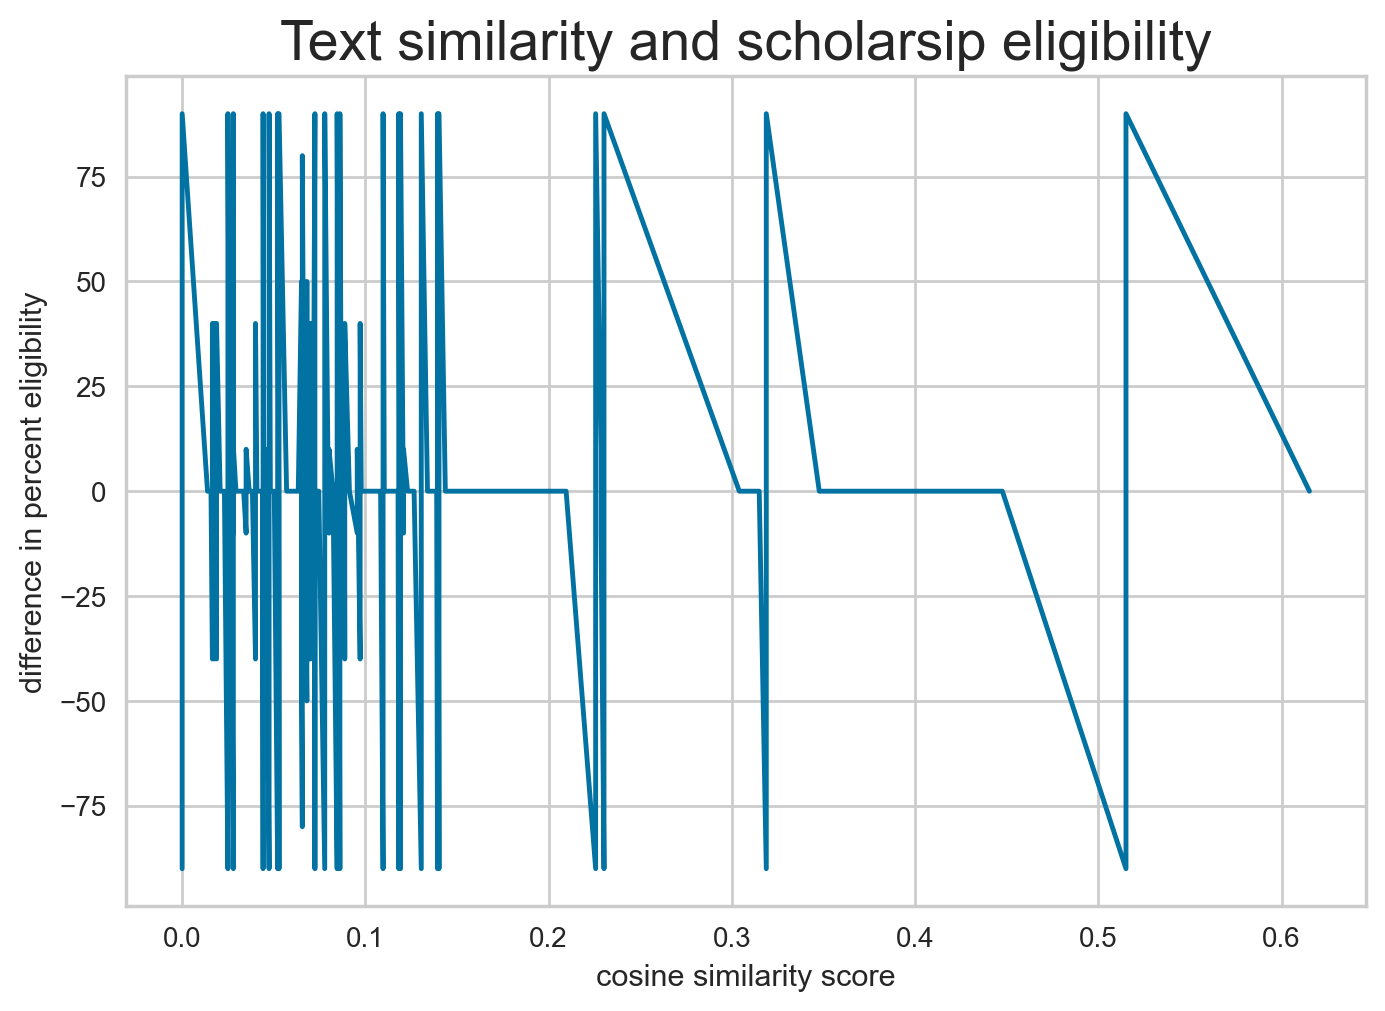

In [18]:
#plot text similarity score and eligibility difference
plt.plot(df_results['score'], df_results['pe_diff'])
plt.title('Text similarity and scholarsip eligibility', fontsize=20)
plt.xlabel('cosine similarity score')
plt.ylabel('difference in percent eligibility')
plt.show()

<br>Most pairs of text have very low similarity scores, with about 83% of scores falling below 10% similarity. We should expect that as cosine similarity goes up the difference between the percent eligibility values should get smaller. The graph does not show a linear relationship or any clear pattern indicating a strong correlation.

## Correlation between features

                score       pe1       pe2       pe_diff
score    1.000000e+00 -0.041988 -0.041988  1.670809e-16
pe1     -4.198784e-02  1.000000 -0.047619  7.237469e-01
pe2     -4.198784e-02 -0.047619  1.000000 -7.237469e-01
pe_diff  1.670809e-16  0.723747 -0.723747  1.000000e+00


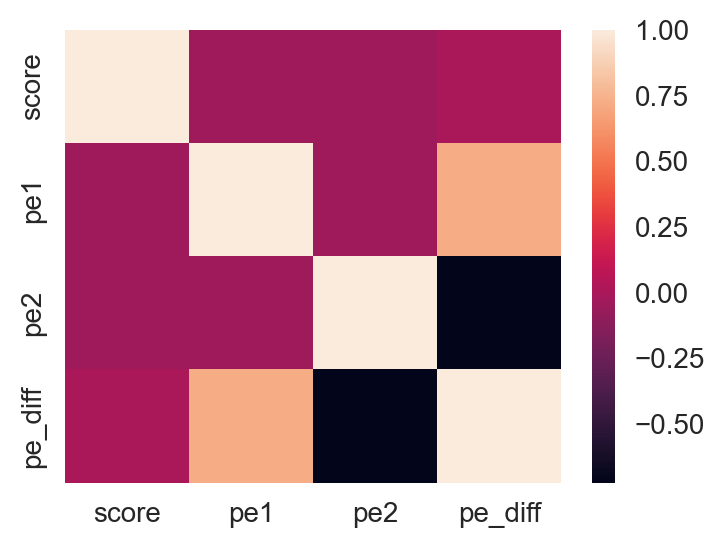

In [19]:
plt.figure(figsize=(4, 3))
corr = df_results.corr(method='pearson')
print(corr)
sns.heatmap(corr)
plt.show()

[To Guide](#guide)
<a id='summarytext'></a>
## 2d. Text analysis summary

<br> Cosine similarity was calculated for each pair of text entries in the dataset. The relationship, or lack of, between similarity scores and percent eligibility was explored. Approximately 83 percent of entry pairs had a similarity of less than 10 percent. Pearson correlation coefficients were calculated for feature pairs. Each percenteligibility value was related to the calculated value of the difference between the scores, as would be expected. The correlation coefficient for the difference and the similarity score was close to zero.
<br>It is not surprising that the notes entries are not closely related to percent eligibility. Collected data such as household income and family structure probably have much larger impacts on the availability of disposable income.

_______________
<a id='regression'></a>
# 3. Linear regression analysis: set parameters and applicant data as predictors of award eligibility

### Response:
- **percent_eligible** - the amount of scholarship award, by tier, that applicant is eligible for.
  - Tiers = 90%, 80%, 70%, 50%, 0%

### Factors that contribute to allocated scholarship amount:
- **household_income** - Amount earned by adults in household.
- **number_adults** - Number of additional adults in household is multiplied by estimated cost of an adult.
- **number_children** - Number of children in household is multiplied by estimate cost of an additional child.
- **single** - binary feature 0 = not single parent, 1 = single parent
- **total_circumstances** - Number of circumstances reported by family.

### Calculated using MIT values
- **single parent value** - additional cost per child for single parent
- **additional_adult** - cost of each additional child in household
- **additional_child** - cost of each additional adult in household

### Set by analyst
- **single_parent_cost** -Single parent additional need: whole = full amount every child; half = full amount first child and half for each additional. 
  - *half: single_parent_cost = ((single_cost + (df_annual['number_children']-1 (single_cost/2))*df_annual['single'])*
  - *whole: single_parent_cost = df_annual['number_children']*single_cost*df_annual['single']*
- **circumstance_cost** - Number of circumstances multiplied by set parameter circumstance_cost level. As circumstance_cost increases, scholarship awards will increase.
  - *low or mid*
- **disposable_unit** - Set parameter defining an amount of disposable income per child (full unit) and adult (half unit); family disposable income is divided by units to determine eligibility tier. As disposable_unit increases, scholarship awards will increase.
  - *low, mid, or high*

### Engineered features 
- **extra_cost**
  - *df_annual['total_circumstances']*circumstance_cost + single_parent_cost*
- **family_base_income**: income family needs to live up to standard
  - *base + ((df_annual['number_adults']-1)*add_adult) + ((df_annual['number_children'])*add_child)*
- **family_need_income**
  - *family_base_income + extra_cost*
- **disposable_income** 
  - *household_income - family_need_income*
- **family_dosposable_unit**: a disposable unit of income as calculated based on family structure and set disposable unit parameter.
  - *(df_annual['number_adults']*(disposable_unit/2)) + (df_annual['number_children']*disposable_unit)*


## 3a. Import data<a id='fabdata'></a>

In [20]:
#get fabricated data and allotments from GitHub: Floydworks
url = ('https://raw.githubusercontent.com/Floydworks/Scholarship_Allocation_Tool/main/data_files/df_fab_awards_long.csv')
download = requests.get(url).content
# Read the downloaded content and turn it into a pandas dataframe
fabricated_scholarship = pd.read_csv(io.StringIO(download.decode('utf-8'))).iloc[:, 1:]
   

In [21]:
#Look at the data
fabricated_df = fabricated_scholarship
fabricated_df

,name,applied,year,household_income,number_adults,number_children,additional_expenses,employment,divorce,medical,education,immigration,housing,total_circumstances,single,family,family_base_income,circumstance_cost_text,circumstance_cost,single_cost_text,single_cost,extra_cost,family_need_income,disposable_income,disposable_unit_text,disposable_unit,family_disposable_unit,percent_eligible,combination
0,a,yes,2022,0,1,1,none,0,0,0,0,0,0,0,1,0,84412.67,mid,2000.0,whole,7704.666667,7704.67,92117.33,-92117.33,hi,7000.0,10500.0,90,12
1,b,yes,2022,0,1,1,none,0,0,0,0,0,0,0,1,0,84412.67,mid,2000.0,whole,7704.666667,7704.67,92117.33,-92117.33,hi,7000.0,10500.0,90,12
2,d,yes,2022,0,2,2,none,0,0,0,0,0,0,0,0,0,126033.67,mid,2000.0,whole,0.000000,0.00,126033.67,-126033.67,hi,7000.0,21000.0,90,12
3,c,yes,2022,0,3,2,none,0,0,0,0,0,0,0,0,0,133705.00,mid,2000.0,whole,0.000000,0.00,133705.00,-133705.00,hi,7000.0,24500.0,90,12
4,e,yes,2022,10000,1,2,none,0,0,0,0,0,0,0,1,0,118362.33,mid,2000.0,whole,15409.333333,15409.33,133771.67,-123771.67,hi,7000.0,17500.0,90,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,vvvv,yes,2022,190000,2,4,"education, medical, housing",0,0,1,1,0,1,3,0,0,193933.00,low,3000.0,half,0.000000,9000.00,202933.00,-12933.00,low,5000.0,25000.0,90,1
1232,wwww,yes,2022,200000,2,1,none,0,0,0,0,0,0,0,0,0,92084.00,low,3000.0,half,0.000000,0.00,92084.00,107916.00,low,5000.0,10000.0,0,1
1233,xxxx,yes,2022,200000,3,2,none,0,0,0,0,0,0,0,0,0,133705.00,low,3000.0,half,0.000000,0.00,133705.00,66295.00,low,5000.0,17500.0,0,1
1234,yyyy,yes,2022,220000,2,4,we have two children in college,0,0,0,1,0,0,1,0,0,193933.00,low,3000.0,half,0.000000,3000.00,196933.00,23067.00,low,5000.0,25000.0,80,1


## 3b. Model features

### Table of parameter combinations<a id='paramcombos'></a>

In [22]:
fabricated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    1236 non-null   object 
 1   applied                 1236 non-null   object 
 2   year                    1236 non-null   int64  
 3   household_income        1236 non-null   int64  
 4   number_adults           1236 non-null   int64  
 5   number_children         1236 non-null   int64  
 6   additional_expenses     1236 non-null   object 
 7   employment              1236 non-null   int64  
 8   divorce                 1236 non-null   int64  
 9   medical                 1236 non-null   int64  
 10  education               1236 non-null   int64  
 11  immigration             1236 non-null   int64  
 12  housing                 1236 non-null   int64  
 13  total_circumstances     1236 non-null   int64  
 14  single                  1236 non-null   

In [23]:
#fabricated_df.describe()

In [24]:
# create a table of combination number and parameter settings for that combination
fab_param_table = fabricated_df[['combination', 'single_cost_text', 'circumstance_cost_text', 'disposable_unit_text']]
fab_param_table.drop_duplicates().sort_values(by='combination').reset_index(drop=True)


,combination,single_cost_text,circumstance_cost_text,disposable_unit_text
0,1,half,low,low
1,2,half,low,mid
2,3,half,low,hi
3,4,whole,low,low
4,5,whole,low,mid
5,6,whole,low,hi
6,7,half,mid,low
7,8,half,mid,mid
8,9,half,mid,hi
9,10,whole,mid,low


### correlation heatmap

In [25]:
df_corr=fabricated_df[['household_income', 'number_adults',
       'number_children', 'additional_expenses', 'employment', 'divorce',
       'medical', 'education', 'immigration', 'housing', 'total_circumstances',
       'single', 'family_base_income', 
       'circumstance_cost', 'single_cost', 'extra_cost',
       'family_need_income', 'disposable_income', 
       'disposable_unit', 'family_disposable_unit', 'percent_eligible',
       'combination']]

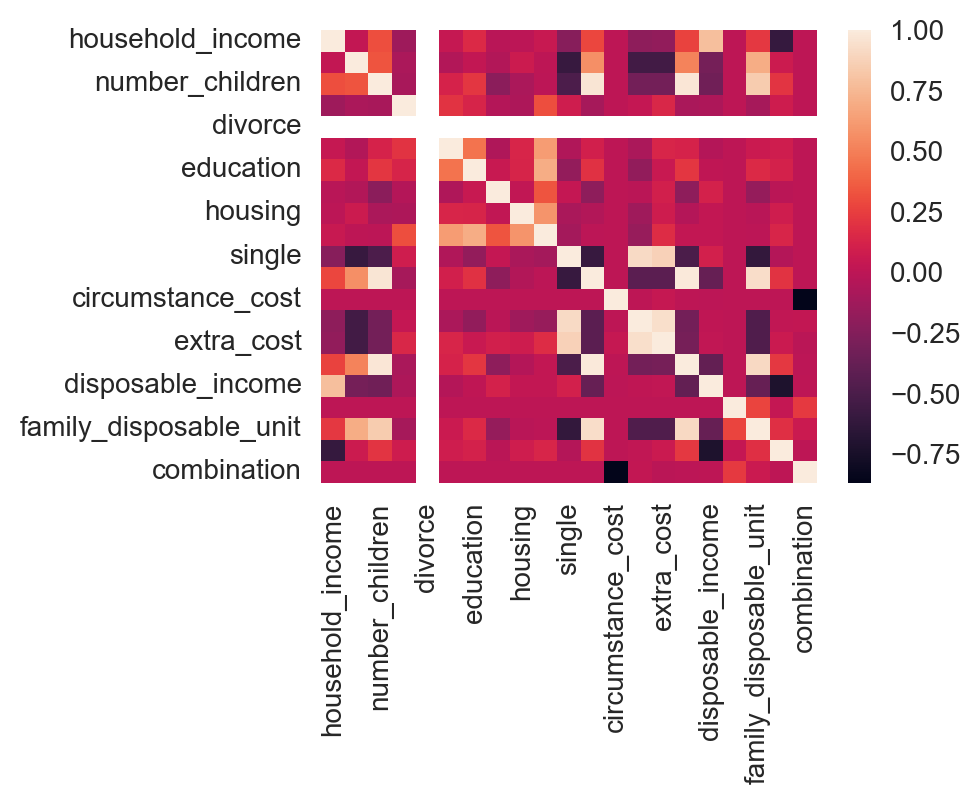

In [26]:
plt.figure(figsize=(4, 3))
corr = df_corr.corr(method='pearson')
#print(corr)
sns.heatmap(corr)
plt.show()

[To Guide](#guide)
## 3c. Linear regression model: Ordinary Least Squares<a id='model'></a>

In [27]:
#get dummy variables for parameter levels
fabricated_df = pd.get_dummies(fabricated_df)

### Linear regression: full model<a id='fullmodel'></a>
**Dropped features:**
<br>'family' was not ised in the algorithm
<br> numeric parameter level values are dropped

In [28]:
# Linear regression full model keeping 25 features
#remove: 'family, 'circumstance_cost', 'single_cost', 'disposable_unit',  'combination', 

X = fabricated_df[['household_income', 'number_adults', 'number_children', 
                          'employment', 'divorce', 'medical', 'education', 'immigration', 'housing',
                          'total_circumstances', 'single','family_base_income',
                          'extra_cost', 'family_need_income',
                          'disposable_income', 'family_disposable_unit',
                          'circumstance_cost_text_low', 'circumstance_cost_text_mid', 
                          'single_cost_text_half', 'single_cost_text_whole', 
                          'disposable_unit_text_hi', 'disposable_unit_text_low', 'disposable_unit_text_mid']]
y = fabricated_df['percent_eligible']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42 )


In [29]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [30]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [31]:
# Train the model using the training sets
regr.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
# Make predictions using the testing set
y_pred = regr.predict(X_test_scaled)

In [33]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [-1.45078330e+06  8.62982351e+06  2.59250705e+07  2.82617139e-01
 -2.22964222e-02 -1.03236024e+00  2.58363288e+00  5.11538901e-01
  2.14894041e+00  2.06036984e+00 -2.49120644e-01 -2.41524975e+07
  8.18043452e+05 -4.55612972e+06  1.54515633e+06 -3.55730527e+00
 -6.70740326e-03 -5.27444358e-02  6.97241634e-02 -7.62132418e-02
  7.82204882e-01 -1.19728718e+00  4.09389020e-01]
Mean squared error: 371.76
Coefficient of determination: 0.58


In [34]:
#get list of features from model
features = list(X_test.columns)
#create dataframe with feature names and coefficients
feature_df = pd.DataFrame({'feature':features, 'coefs':regr.coef_}).reset_index(drop=True)
feature_df['coef_abs'] = abs(feature_df['coefs'])
print(feature_df.sort_values(by='coef_abs'))

                       feature         coefs      coef_abs
16  circumstance_cost_text_low -6.707403e-03  6.707403e-03
4                      divorce -2.229642e-02  2.229642e-02
17  circumstance_cost_text_mid -5.274444e-02  5.274444e-02
18       single_cost_text_half  6.972416e-02  6.972416e-02
19      single_cost_text_whole -7.621324e-02  7.621324e-02
10                      single -2.491206e-01  2.491206e-01
3                   employment  2.826171e-01  2.826171e-01
22    disposable_unit_text_mid  4.093890e-01  4.093890e-01
7                  immigration  5.115389e-01  5.115389e-01
20     disposable_unit_text_hi  7.822049e-01  7.822049e-01
5                      medical -1.032360e+00  1.032360e+00
21    disposable_unit_text_low -1.197287e+00  1.197287e+00
9          total_circumstances  2.060370e+00  2.060370e+00
8                      housing  2.148940e+00  2.148940e+00
6                    education  2.583633e+00  2.583633e+00
15      family_disposable_unit -3.557305e+00  3.557305e+

### Plot the residuals

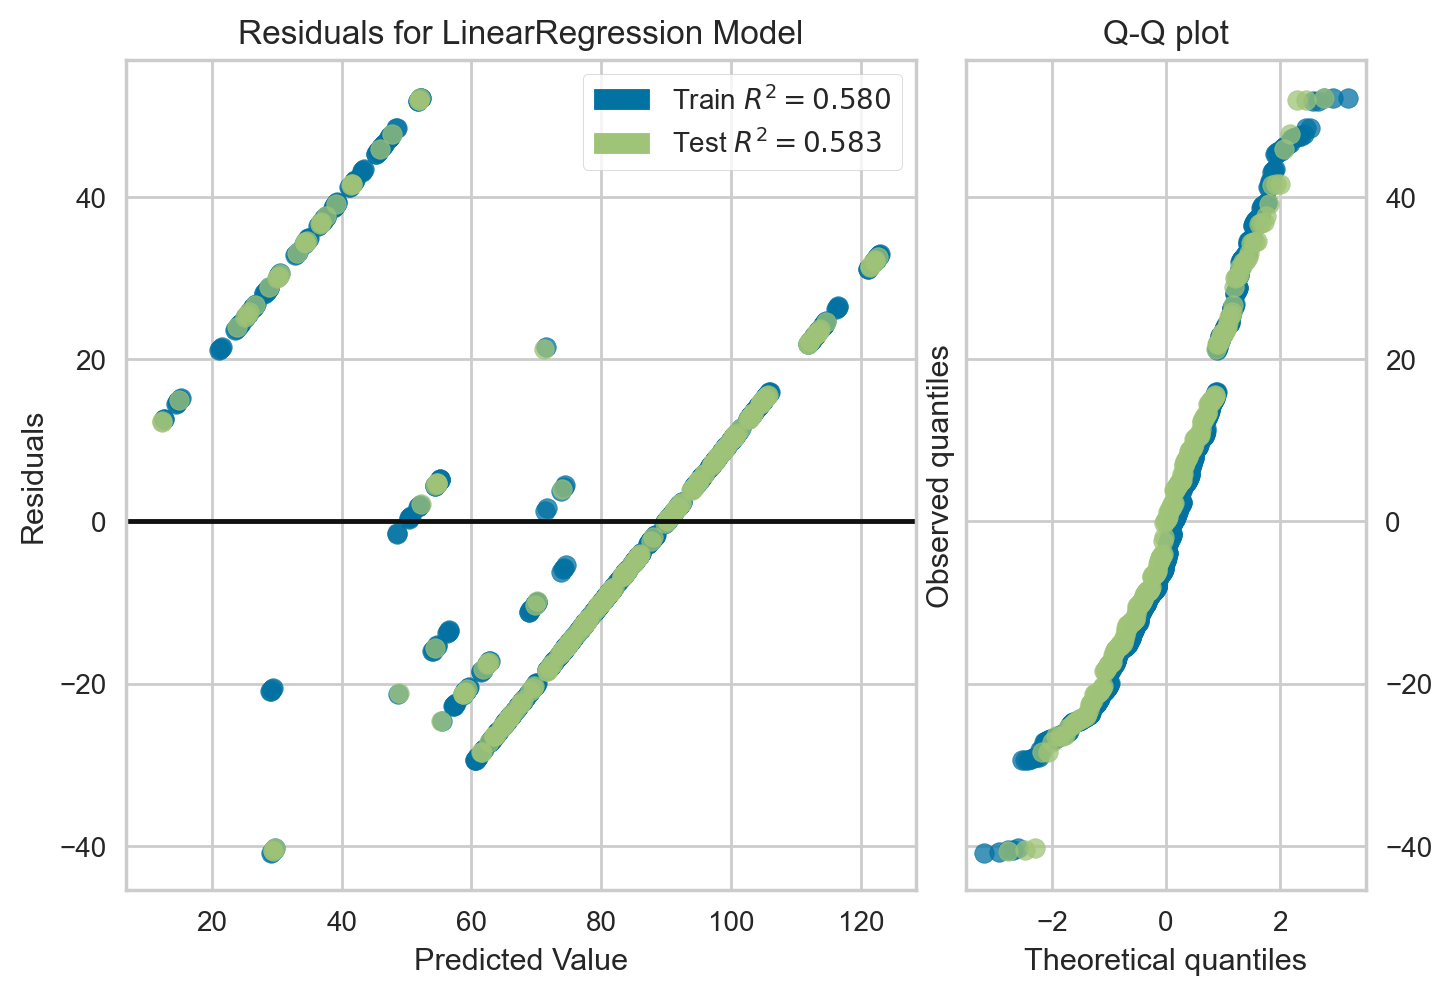

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
# make a model object 
model=regr.fit(X_train_scaled, y_train)

#instantiate the visualizer
visualizer = ResidualsPlot(model, hist=False, qqplot=True)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


### Linear regression: reduced model<a id='reducedmodel'></a>

In [36]:
#removed: 'employment', 'divorce', 'medical', 'education', 'immigration', 'housing', 'combination', 
#'family_base_income','extra_cost', 'family_need_income', 'disposable_income', 'family_disposable_unit',
                          
X = fabricated_df[['household_income', 'number_adults', 'number_children', 
                          'total_circumstances', 'single',          
                          'circumstance_cost_text_low', 'circumstance_cost_text_mid', 
                          'single_cost_text_half', 'single_cost_text_whole', 
                          'disposable_unit_text_hi', 'disposable_unit_text_low', 'disposable_unit_text_mid']]
y = fabricated_df['percent_eligible']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42 )


In [37]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [38]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [39]:
# Train the model using the training sets
regr.fit(X_train_scaled, y_train)

LinearRegression()

In [40]:
y_pred = regr.predict(X_test_scaled)

In [41]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [-22.68185411  -2.78808471  13.77392284   4.77176269  -0.49435854
   0.02405431  -0.02405431   0.12155895  -0.12155895   0.31002251
  -0.56825466   0.25775518]
Mean squared error: 395.07
Coefficient of determination: 0.56


In [42]:
#get list of features from model
features = list(X_test.columns)
#create dataframe with feature names and coefficients
feature_df = pd.DataFrame({'feature':features, 'coefs':regr.coef_}).reset_index(drop=True)
feature_df['coef_abs'] = abs(feature_df['coefs'])
print(feature_df.sort_values(by='coef_abs'))

                       feature      coefs   coef_abs
5   circumstance_cost_text_low   0.024054   0.024054
6   circumstance_cost_text_mid  -0.024054   0.024054
7        single_cost_text_half   0.121559   0.121559
8       single_cost_text_whole  -0.121559   0.121559
11    disposable_unit_text_mid   0.257755   0.257755
9      disposable_unit_text_hi   0.310023   0.310023
4                       single  -0.494359   0.494359
10    disposable_unit_text_low  -0.568255   0.568255
1                number_adults  -2.788085   2.788085
3          total_circumstances   4.771763   4.771763
2              number_children  13.773923  13.773923
0             household_income -22.681854  22.681854


### Plot the residuals

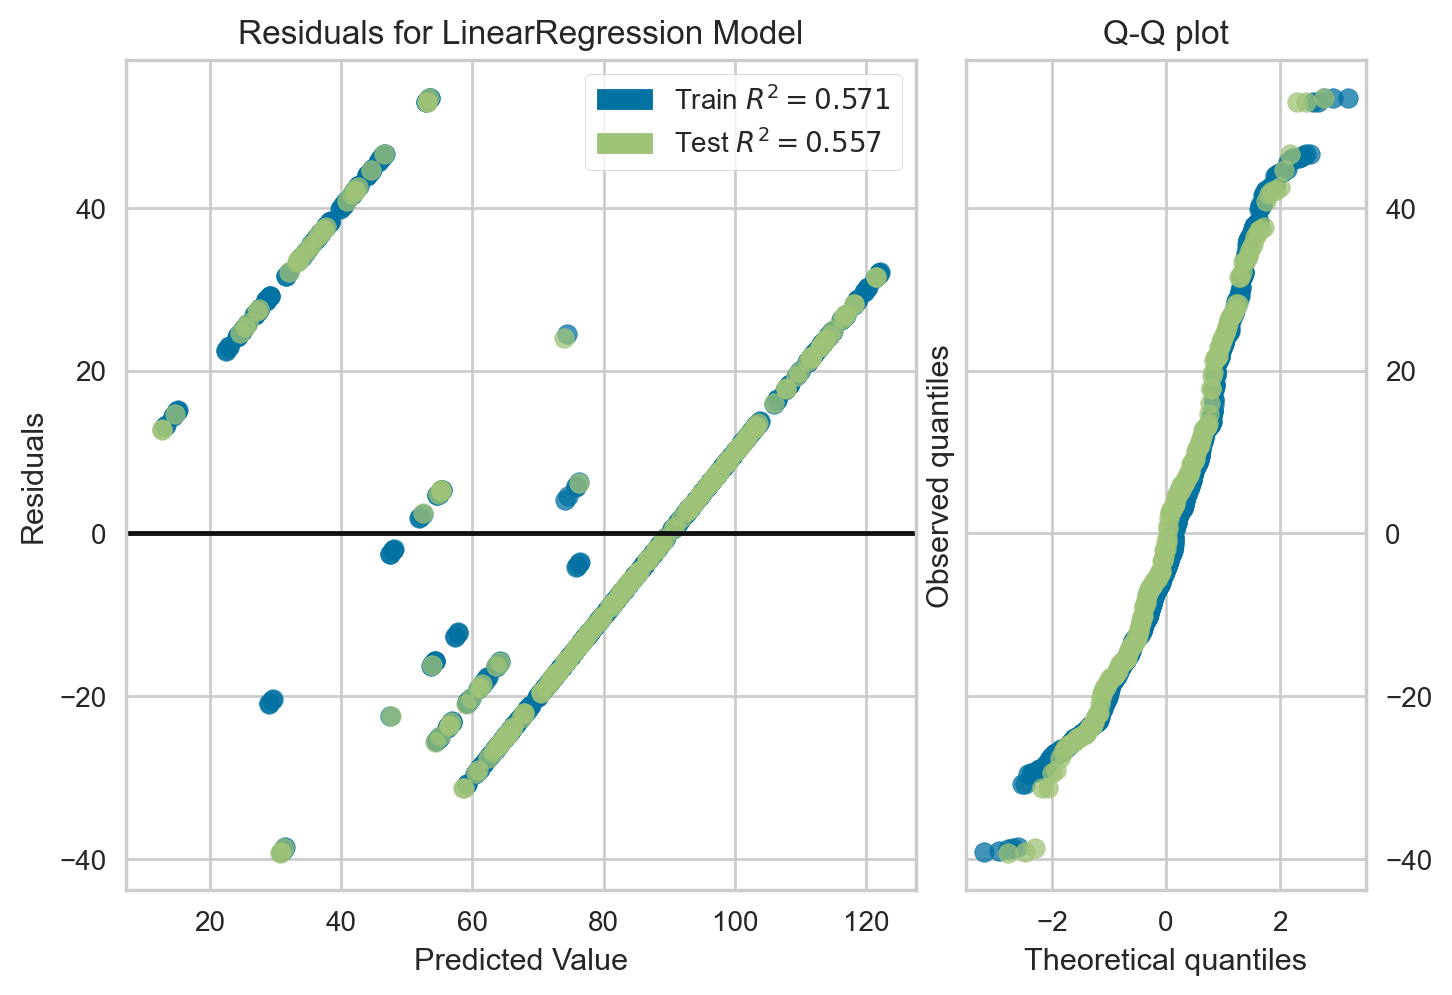

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
# make a model object 
model=regr.fit(X_train_scaled, y_train)

#instantiate the visualizer
visualizer = ResidualsPlot(model, hist=False, qqplot=True)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


## 3d. Poisson, Generalized Linear Model<a id='poisson'></a>

In [44]:
#removed: 'employment', 'divorce', 'medical', 'education', 'immigration', 'housing', 'combination', 
#'family_base_income','extra_cost', 'family_need_income', 'disposable_income', 'family_disposable_unit',
                          
X = fabricated_df[['household_income', 'number_adults', 'number_children', 
                          'total_circumstances', 'single',          
                          'circumstance_cost_text_low', 'circumstance_cost_text_mid', 
                          'single_cost_text_half', 'single_cost_text_whole', 
                          'disposable_unit_text_hi', 'disposable_unit_text_low', 'disposable_unit_text_mid']]
y = fabricated_df['percent_eligible']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42 )


In [45]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [46]:
# Create poisson regression object
poisson_regr = linear_model.PoissonRegressor(alpha=1.0, fit_intercept=True, 
                                       max_iter=100, tol=0.0001, warm_start=False, verbose=0)

#solver='lbfgs', 

In [47]:
# Train the model using the training sets
poisson_regr.fit(X_train_scaled, y_train)

PoissonRegressor()

In [48]:
y_pred = poisson_regr.predict(X_test_scaled)

In [50]:
# The coefficients
print("Coefficients: \n", poisson_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [-0.31607541 -0.03579605  0.18488404  0.07264768  0.00086812  0.00042093
 -0.00042093  0.00123076 -0.00123076  0.0037847  -0.00650174  0.0027074 ]
Mean squared error: 537.09
Coefficient of determination: 0.40


In [51]:
#get list of features from model
features = list(X_test.columns)
#create dataframe with feature names and coefficients
feature_df = pd.DataFrame({'feature':features, 'coefs':poisson_regr.coef_}).reset_index(drop=True)
feature_df['coef_abs'] = abs(feature_df['coefs'])
print(feature_df.sort_values(by='coef_abs'))

                       feature     coefs  coef_abs
6   circumstance_cost_text_mid -0.000421  0.000421
5   circumstance_cost_text_low  0.000421  0.000421
4                       single  0.000868  0.000868
7        single_cost_text_half  0.001231  0.001231
8       single_cost_text_whole -0.001231  0.001231
11    disposable_unit_text_mid  0.002707  0.002707
9      disposable_unit_text_hi  0.003785  0.003785
10    disposable_unit_text_low -0.006502  0.006502
1                number_adults -0.035796  0.035796
3          total_circumstances  0.072648  0.072648
2              number_children  0.184884  0.184884
0             household_income -0.316075  0.316075


### Plot the residuals¶

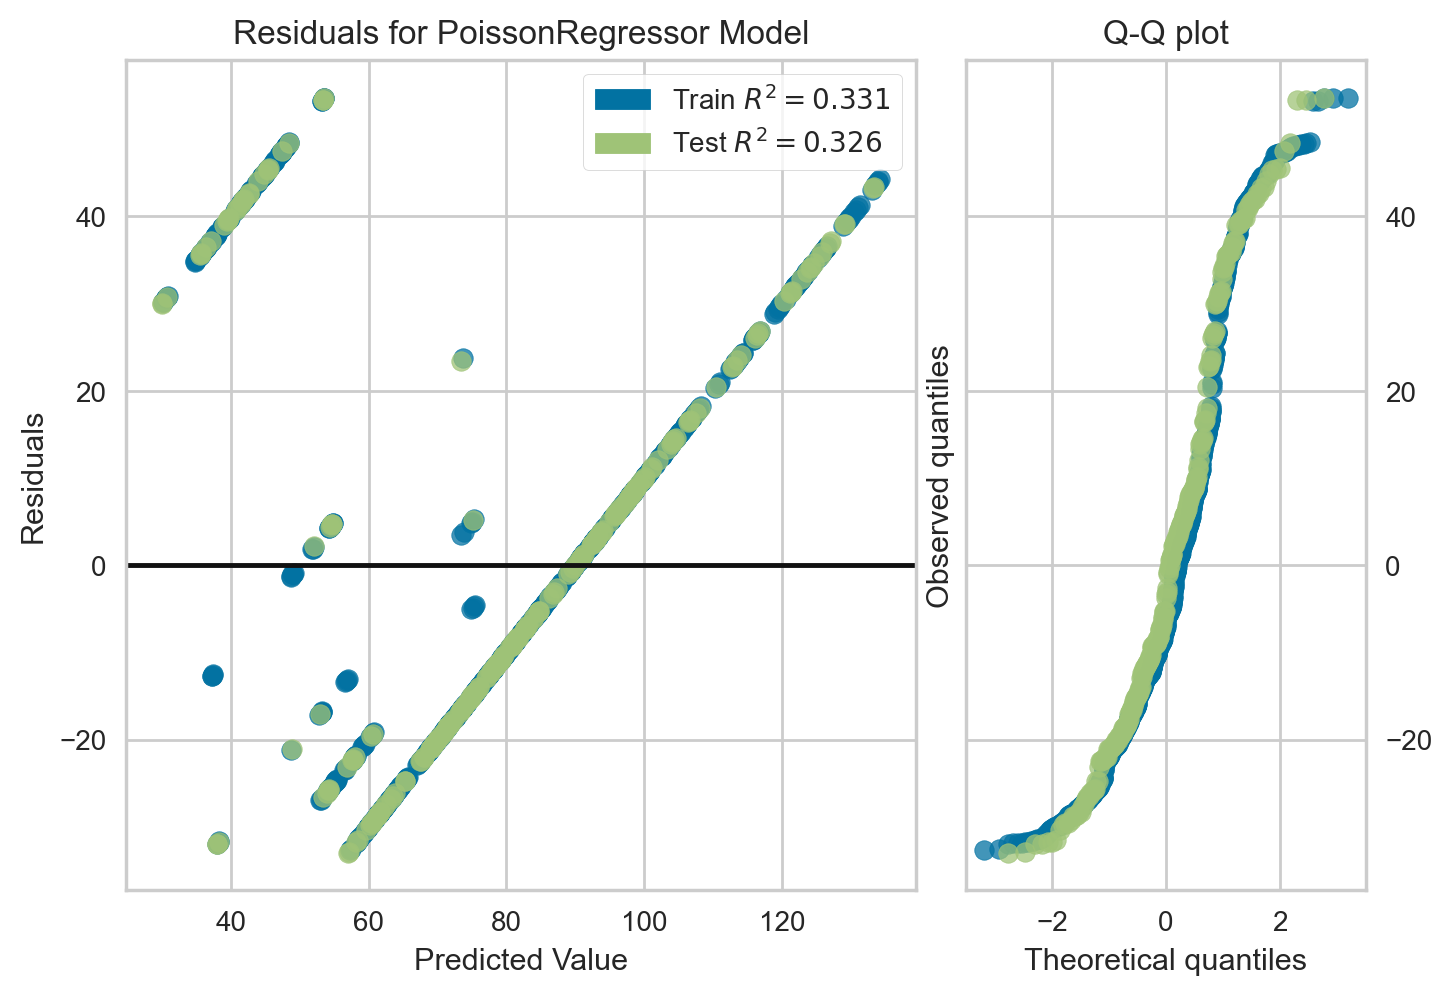

<AxesSubplot:title={'center':'Residuals for PoissonRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [52]:
# make a model object 
model=poisson_regr.fit(X_train_scaled, y_train)

#instantiate the visualizer
visualizer = ResidualsPlot(model, hist=False, qqplot=True)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


## 3e. Ridge regressor<a id='ridge'></a>

In [53]:
#removed: 'employment', 'divorce', 'medical', 'education', 'immigration', 'housing', 'combination', 
#'family_base_income','extra_cost', 'family_need_income', 'disposable_income', 'family_disposable_unit',
                          
X = fabricated_df[['household_income', 'number_adults', 'number_children', 
                          'total_circumstances', 'single',          
                          'circumstance_cost_text_low', 'circumstance_cost_text_mid', 
                          'single_cost_text_half', 'single_cost_text_whole', 
                          'disposable_unit_text_hi', 'disposable_unit_text_low', 'disposable_unit_text_mid']]
y = fabricated_df['percent_eligible']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42 )


In [54]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [93]:
# Create ridge regression object
ridge_regr = linear_model.Ridge(alpha=50.0, fit_intercept=True, copy_X=True, max_iter=None, 
                                tol=0.0001, solver='auto', positive=False,  random_state=42)



In [94]:
# Train the model using the training sets
ridge_regr.fit(X_train_scaled, y_train)

Ridge(alpha=50.0, random_state=42, tol=0.0001)

In [95]:
y_pred = ridge_regr.predict(X_test_scaled)

In [96]:
# The coefficients
print("Coefficients: \n", ridge_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [-21.22802544  -2.24278078  12.52586255   4.45108736  -0.48333113
   0.03572441  -0.03572441   0.11561584  -0.11561584   0.27845023
  -0.53056971   0.25186798]
Mean squared error: 392.63
Coefficient of determination: 0.56


In [80]:
#get list of features from model
features = list(X_test.columns)
#create dataframe with feature names and coefficients
feature_df = pd.DataFrame({'feature':features, 'coefs':ridge_regr.coef_}).reset_index(drop=True)
feature_df['coef_abs'] = abs(feature_df['coefs'])
print(feature_df.sort_values(by='coef_abs'))

                       feature      coefs   coef_abs
6   circumstance_cost_text_mid  -0.045215   0.045215
5   circumstance_cost_text_low   0.045215   0.045215
8       single_cost_text_whole  -0.110532   0.110532
7        single_cost_text_half   0.110532   0.110532
11    disposable_unit_text_mid   0.246919   0.246919
9      disposable_unit_text_hi   0.251854   0.251854
4                       single  -0.479262   0.479262
10    disposable_unit_text_low  -0.498835   0.498835
1                number_adults  -1.812851   1.812851
3          total_circumstances   4.171491   4.171491
2              number_children  11.476402  11.476402
0             household_income -19.963227  19.963227


### Plot the residuals¶

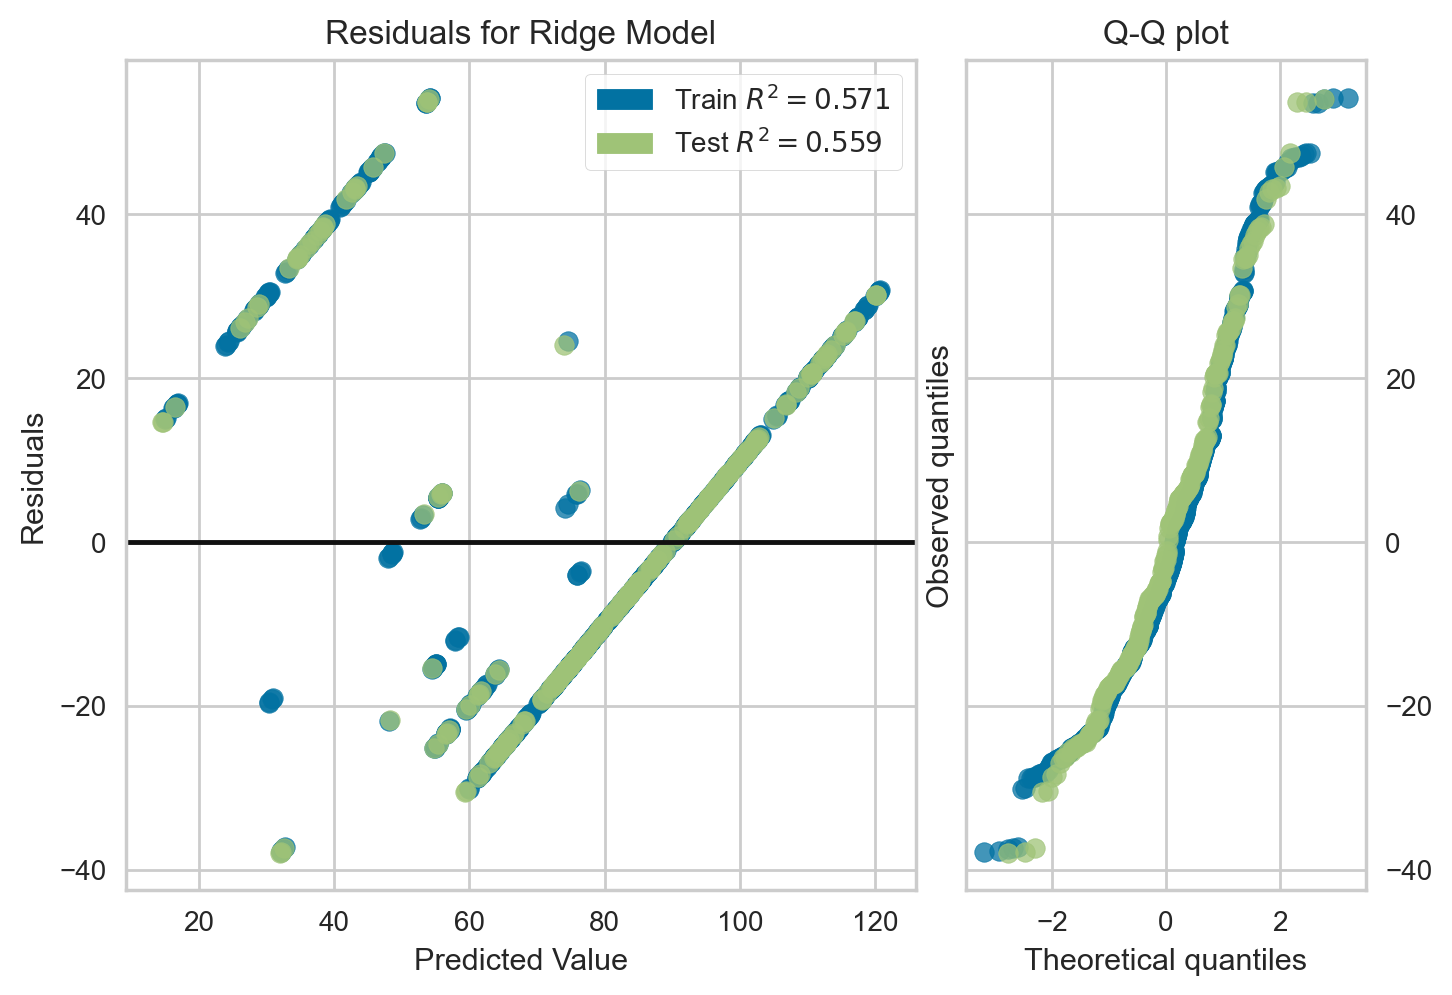

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [71]:
# make a model object 
model=ridge_regr.fit(X_train_scaled, y_train)

#instantiate the visualizer
visualizer = ResidualsPlot(model, hist=False, qqplot=True)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


[To Guide](#guide)
<a id='evaluation'></a>
## 4. Model evaluation and summary:
**Coefficients:** A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease. The coefficient value signifies how much the mean of the dependent variable changes given a one-unit shift in the independent variable while holding other variables in the model constant.
<br>**MSE:** As model error increases, its value increases.
<br>**Coefficient of determination:** denoted as 𝑅², tells you which amount of variation in 𝑦 can be explained by the dependence on 𝐱, using the particular regression model. A larger 𝑅² indicates a better fit and means that the model can better explain the variation of the output with different inputs.
<br>
<br>**Summary:**
<br>The ridge regression model performed best. The r-squared value, r-squared = 0.56 , indicates that 56% of the variation in the data can be explained by the features included. The mean squared error was 395.07, which is high and points to a large amount of error in the model. This was a similar performance to the reduced ordinary least squares model. The full ordinary least squares model had a slightly higher r-squared value, r-squared = 0.583, but its interpretation is much more complicated with engineered values being related to other explanatory variables.  
<br>
<br>As we would expect, household income has the largest effect on award and as income increases, award values decrease. The number of children in the household and total_circumstances are positively related to the amount of award, and this is also intuitive. A household with more income and a greater number of additional financial circumstances will require more income and receive larger awards.
<br>
<br>Other featuers had a fairly low influence on awards. Higher set values of disposable_income_units lead to lower awards. Single_cost and circumstance_cost settings have a very small effect on awards in comparison to the major features, household_income, number_children, total_circumstances, and number_adults. Interestingly, being a single parent was associated with a lower award despite increasing the calculated financial need, but the effect was very small. The cost of having an additional adult may outweigh the additional need awarded to a single parent.